# Capstone Two: Data Wrangling

## 1. Introduction

The purpose of this data wrangling exercise is to ensure I have sufficient and quality data to use in developing a price prediction model. 

The dataset used in this project was obtained from https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset 
The Kaggle command API is !kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

The definitions of the columns in the dataset are:

status = Housing status - ready for sale or, ready to build;

bed  = number of beds;

bath = number of bathrooms;

acre_lot = Property / Land size in acres;

city = name of the city where house is located;

state = name of the state;

zip_code = postal code of the area;

house_size = square footage for the house;

prev_sold_date = previous date when the house was last sold;

price = Housing price, it is either the current listing price or recently sold price if the house was sold recently.

### 1.1 Objectives

Clean the data and ensure it is sufficient to test whether house attributes such as number of bedrooms, bathrooms, as well as location and lot_size correlate with price. Also, if I can predict housing prices based on the features.

## 2. Imported Packages and Libraries

In [1]:
# Import packages and libraries
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings

## 3. Load the Real Estate Data

In [2]:
# Load the original dataset
df = pd.read_csv('US_housingdata.csv')

In [3]:
# Create a copy of the original dataset
df2 = df.copy()
df2.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [4]:
print(df2.shape)

(1048575, 12)


## 4. Data Definitions: Column Descriptions and Data Types

In [5]:
# An overview of the dataset: Th number of columns, rows, datatypes.
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   brokered_by     1047537 non-null  float64
 1   status          1048575 non-null  object 
 2   price           1047485 non-null  float64
 3   bed             738569 non-null   float64
 4   bath            723607 non-null   float64
 5   acre_lot        870247 non-null   float64
 6   street          1041799 non-null  float64
 7   city            1047715 non-null  object 
 8   state           1048568 non-null  object 
 9   zip_code        1048416 non-null  float64
 10  house_size      683689 non-null   float64
 11  prev_sold_date  497886 non-null   object 
dtypes: float64(8), object(4)
memory usage: 96.0+ MB


In [6]:
# Counting Unique Values
df2.nunique()

brokered_by        68401
status                 2
price              64983
bed                   82
bath                  67
acre_lot           12506
street            988483
city               15973
state                 47
zip_code           23722
house_size         10293
prev_sold_date     13847
dtype: int64

In [7]:
# Percent of unique values
df2.nunique() / df2.size*100

brokered_by       0.543603
status            0.000016
price             0.516439
bed               0.000652
bath              0.000532
acre_lot          0.099389
street            7.855765
city              0.126942
state             0.000374
zip_code          0.188526
house_size        0.081801
prev_sold_date    0.110046
dtype: float64

## 5. Data Cleaning

### 5.1 Duplicate Values

In [8]:
# Count duplicates
duplicates = df2.duplicated(keep = False).sum()
print(f'Number of duplicate values: {duplicates}')

Number of duplicate values: 0


There are no duplicate values in the data.

### 5.2 Missing and NaN values

In [9]:
missing = pd.concat([df2.isna().sum(), 100 * df2.isna().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count', ascending=False)

,count,%
prev_sold_date,550689,52.517846
house_size,364886,34.798274
bath,324968,30.991393
bed,310006,29.564504
acre_lot,178328,17.006700
street,6776,0.646210
price,1090,0.103951
brokered_by,1038,0.098991
city,860,0.082016
zip_code,159,0.015163


The prev_sold_date feature has the highest number of missing values at 53%. House_size, bath, bed, and acre_lot have 35%, 31%, 30%, and 17% of missing data, respectively.

Drop the data entries of zero or NaN in the 'price' column. The price of zero on a house would seem to be an obvious error in data entry. NaN rows were dropped because they were very few and the remaining data is sufficient to meet the set goal.

In [10]:
# Count the number of values in the 'price' column that are either 0, 0.0 or NaN
price_zero_or_nan = df2['price'].isin([0, 0.0, np.nan]).sum()

print(f"Number of values in the 'price' column that are either 0.0 or NaN:", price_zero_or_nan)

Number of values in the 'price' column that are either 0.0 or NaN: 1211


In [11]:
# Drop rows with 0, 0.0, or NaN in the 'price' column
df2 = df2[(df2['price'] != 0) & (df2['price'] != 0.0) & ~df2['price'].isna()]

# Reset index after dropping rows
df2.reset_index(drop=True, inplace=True)

#Display results
print(df2.shape)

(1047364, 12)


The column with the date when a house was previously sold has a lot missing data. I would not want to drop these values because it may contain other useful data. However, the dataset is very large and sufficient for the current project and would drop missing values in house_size, bath, bed, and acre_lot columns. By so doing, I believe I will have a much cleaner dataset that reflect actual conditions.

In [12]:
# Drop rows with missing values in house_size, bath, bed, and acre_lot columns
df_cleaned = df.dropna(subset=['house_size', 'bath', 'bed', 'acre_lot'])
print(df_cleaned.shape)
df_cleaned.head()

(526989, 12)


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
5,103378.0,for_sale,179000.0,4.0,3.0,0.46,1850806.0,San Sebastian,Puerto Rico,612.0,2520.0,NaN


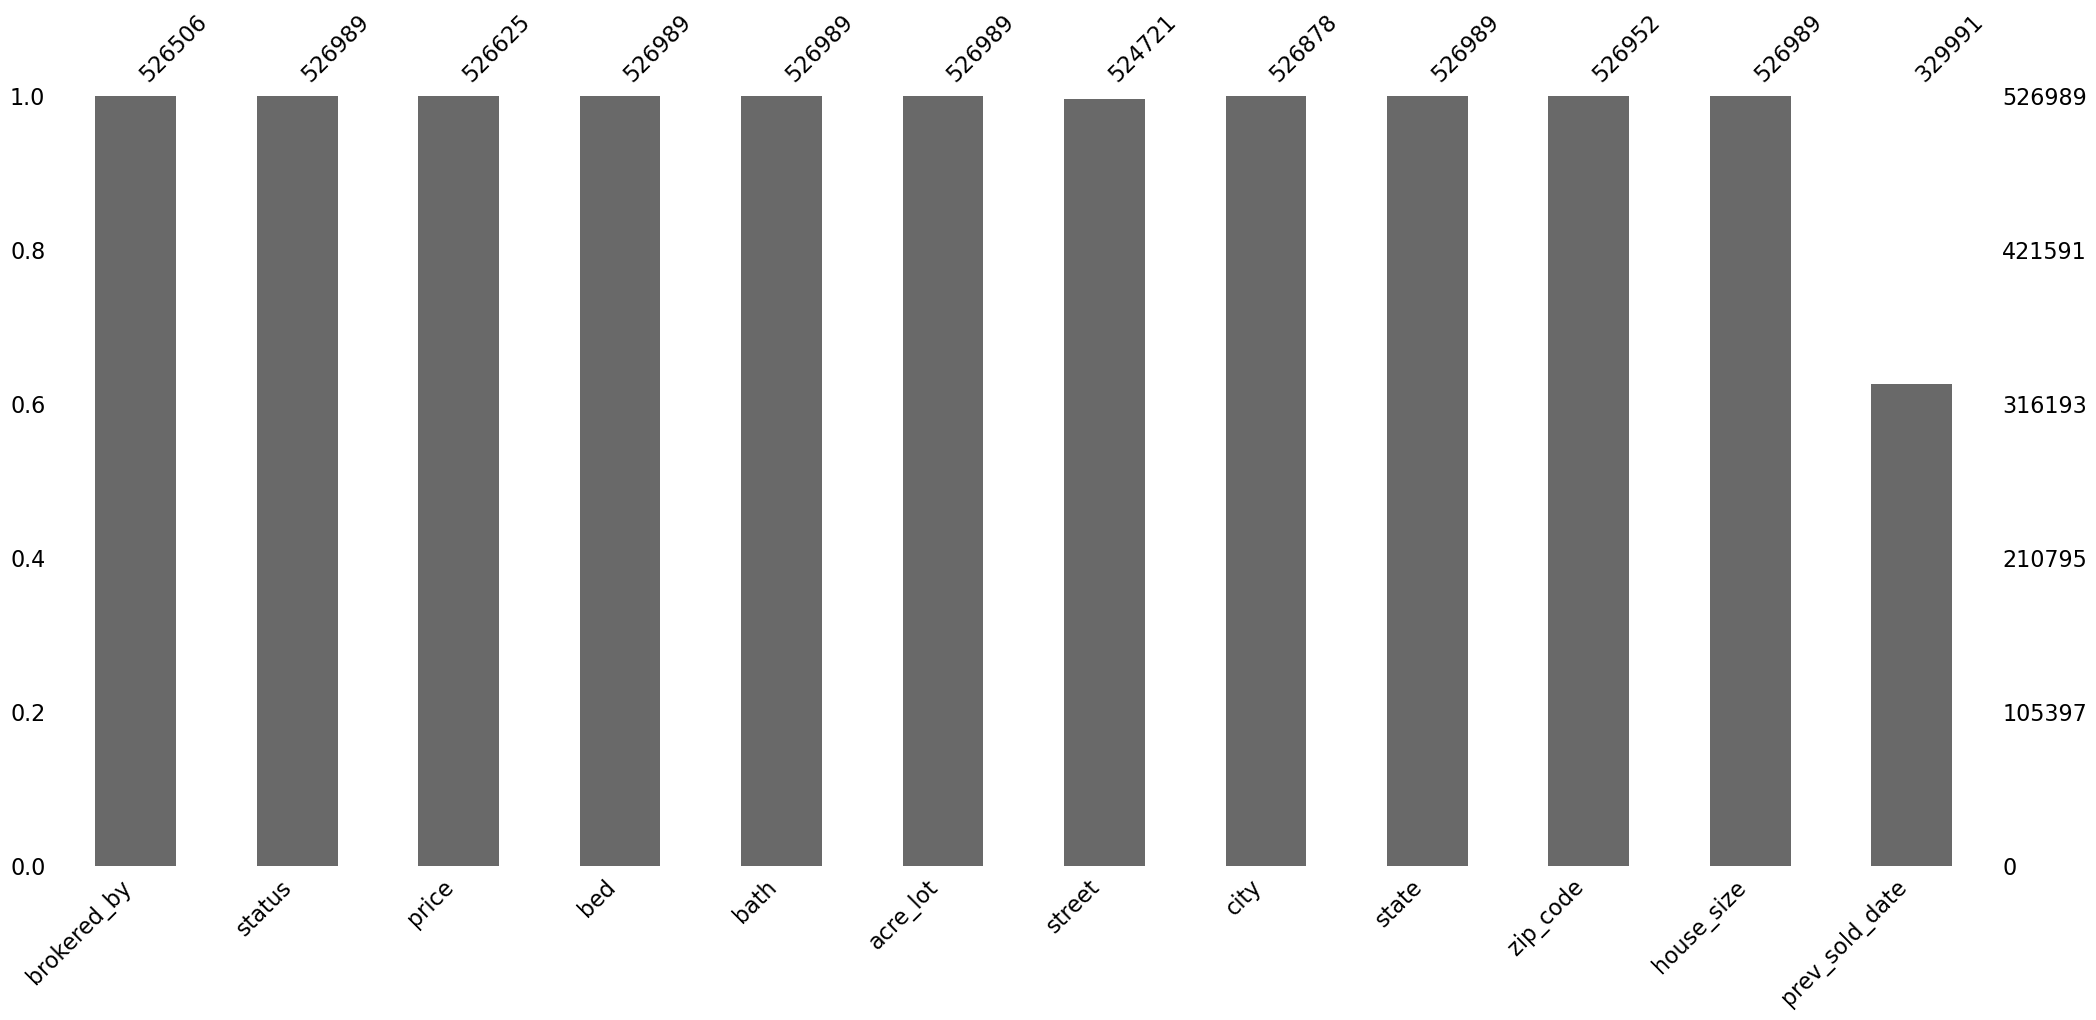

In [13]:
msno.bar(df_cleaned);

In [14]:
# Convert columns from floats to strings
df_cleaned['zip_code'] = df_cleaned['zip_code'].apply(lambda x: str(x).rstrip('.0'))
df_cleaned['street'] = df_cleaned['street'].apply(lambda x: str(x).rstrip('.0'))
df_cleaned['brokered_by'] = df_cleaned['brokered_by'].apply(lambda x: str(x).rstrip('.0'))

C:\Users\MTIDES\AppData\Local\Temp\ipykernel_25540\1170427158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['zip_code'] = df_cleaned['zip_code'].apply(lambda x: str(x).rstrip('.0'))
C:\Users\MTIDES\AppData\Local\Temp\ipykernel_25540\1170427158.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['street'] = df_cleaned['street'].apply(lambda x: str(x).rstrip('.0'))
C:\Users\MTIDES\AppData\Local\Temp\ipykernel_25540\1170427158.py:4: SettingWithCopyWarning: 
A value is trying to be s

In [15]:
df_cleaned.describe().T

,count,mean,std,min,25%,50%,75%,max
price,526625.0,522016.652295,3.175577e+06,0.0,200000.00,331235.00,525000.00,2.147484e+09
bed,526989.0,3.449825,1.349672e+00,1.0,3.00,3.00,4.00,1.900000e+02
bath,526989.0,2.587997,1.396111e+00,1.0,2.00,2.00,3.00,1.980000e+02
acre_lot,526989.0,13.626309,8.365371e+02,0.0,0.15,0.25,0.61,1.000000e+05
house_size,526989.0,2204.869390,3.578815e+03,100.0,1388.00,1862.00,2586.00,1.560780e+06


## 5. Conclusion


Visualizing relationships (scatter matrix):


<Figure size 1000x600 with 0 Axes>

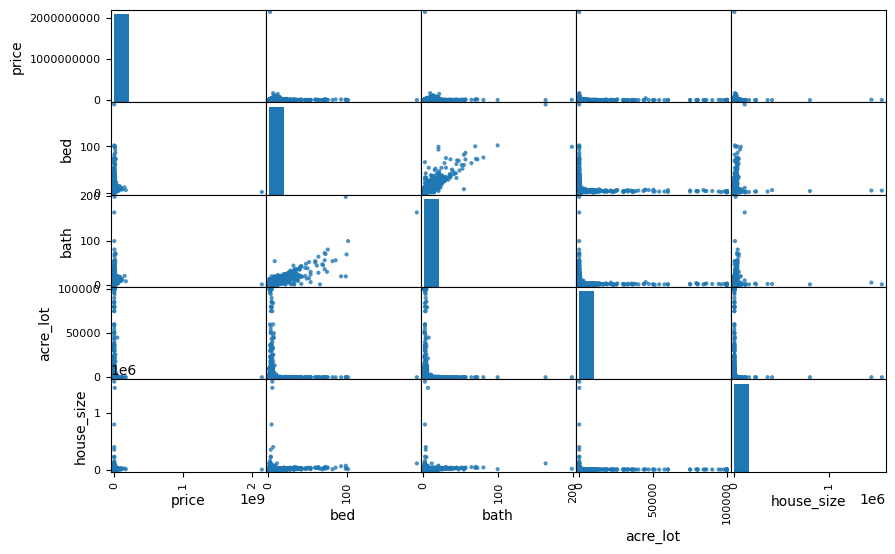

In [16]:
print("\nVisualizing relationships (scatter matrix):")
plt.figure(figsize=(10, 6))
pd.plotting.scatter_matrix(df_cleaned, alpha=0.8, figsize=(10, 6), diagonal='hist')
plt.show();

In [17]:
# Saving data as a csv in a jupyter notebook
df_cleaned.to_csv('housingdata.csv', index=False)